# Machine Learning

In [1]:
import pandas as pd
import sqlite3

import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import gt
import pygwalker as pyg


import seaborn as sns

from nettoyage import Nettoyage
from Graphique import graphique as rep
import utils as fonc
import predictions as pred

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from typing import List, Optional, Tuple, Union

from pandas.core.frame import DataFrame
from pandas.core.series import Series

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from rich.table import Table
import warnings


warnings.filterwarnings('ignore')

# Récupération des données :

La base de données analysée contient 32 631 annonces de montres publiées sur le site Chrono24 au cours de l’année 2024.
Les informations disponibles dans le jeu de données incluent :
- Prix demandé : montant fixé par les vendeurs
- Marque : fabricant de la montre
- Modèle : référence spécifique de la montre
- Type de mouvement : manuel, automatique ou quartz
- État : condition de la montre (neuve, occasion, etc.)
- Sexe : montre pour homme ou femme
- Matière de la lunette
- Matière du verre arrière
- Matière de la boucle
- Nombre de complications : fonctions supplémentaires de la montre

**Problématique :**
Un particulier souhaitant vendre sa montre sur Chrono24 se pose la question suivante :
"À quel prix devrais-je la proposer en fonction de ses caractéristiques ?"

**Approche méthodologique :**
Nous suivrons les étapes suivantes pour répondre à cette problématique :
1.	Préparation des données : nettoyage et traitement des valeurs manquantes ou aberrantes.
2.	Analyse exploratoire : étude des tendances et des relations entre les caractéristiques et le prix de vente.
3.	Modélisation prédictive : mise en place d’un modèle permettant d’estimer le prix idéal en fonction des caractéristiques techniques de la montre.

L’objectif est d’aider les vendeurs à fixer un prix compétitif et réaliste en se basant sur une analyse approfondie des données disponibles.

# Importation et nettoyage de la base de données 

## Avant nettoyage 

In [3]:
path_load = '/Users/f.b/Desktop/Data_Science/Clock_industry/lib/data/montre.db'
path_save = '/Users/f.b/Desktop/Data_Science/Clock_industry/lib/data/base.csv'

In [4]:
def chargement_base(path_load, path_save):
   
        connexion = sqlite3.connect(path_load)

        # Exécution d'une requête SQL pour récupérer des données et conversion en DataFrame
        df = pd.read_sql_query('SELECT * FROM montre', connexion)

        # Fermeture de la connexion
        connexion.close()

        # Conversion de la base en format CSV 
        
        df.to_csv(path_save)

        # Chargement de la BDD sans la colonne id: 
        df = df.iloc[:, 1:]
        return df 

In [5]:
df = chargement_base(path_load, path_save)
nettoyage = Nettoyage(df)

In [6]:
df.head()

,marque,modele,mouvement,matiere_boitier,matiere_bracelet,annee_prod,etat,sexe,prix,reserve_de_marche,...,etencheite,matiere_lunette,matiere_verre,boucle,matiere_boucle,rouage,ville,fonctions,Date_recup,descriptions
0,['Rolex'],"['Datejust', '36']",['automatique'],['Acier'],Acier,2011,"['Très', 'bon', '(Traces', ""d'usure"", 'nulles'...",homme/Unisexe,"['8', '700', '£', '(=', '10', '437', '€)', '[P...",,...,,Acier,['saphir'],['Plis'],['Acier'],,"['Grande-Bretagne,', 'London']",Fonctions\nDate,2024-04-16,None
1,"['Zeno-Watch', 'Basel']","['X-Large', 'Retro']",['automatique'],['Acier'],mm),2023,"['Très', 'bon', '(Traces', ""d'usure"", 'nulles'...",homme/Unisexe,"['699', '€']","['marche', '42', 'h']",...,"['3', 'ATM']",Acier,['saphir'],"['Boucle', 'ardillon']",['Acier'],2824-2,"['Espagne,', 'Valencia']",Fonctions\nDate,2024-04-16,None
2,['Rolex'],"['Yacht-Master', '40']",['automatique'],['Or/Acier'],Or/Acier,2022,"['Très', 'bon', '(Traces', ""d'usure"", 'nulles'...",homme/Unisexe,"['89', '900', 'zł', '(=', '21', '215', '€)', '...","['marche', '70', 'h']",...,"['10', 'ATM']",rose,['saphir'],['Plis'],"['Or', 'rose']",automatyczny,"['Pologne,', 'Warszawa']",Fonctions\nDate,2024-04-16,None
3,['Rolex'],"['Datejust', 'II']",['automatique'],['Acier'],Acier,2016,"['Très', 'bon', '(Traces', ""d'usure"", 'nulles'...",homme/Unisexe,"['8', '700', '£', '(=', '10', '437', '€)']",,...,,,['saphir'],['Plis'],['Acier'],,"['Grande-Bretagne,', 'Bishops', 'Stortford']",Fonctions\nDate,2024-04-16,None
4,['Tudor'],,['automatique'],[],Acier,1975,"['Très', 'bon', '(Traces', ""d'usure"", 'nulles'...",homme/Unisexe,"['16', '500', '€']",,...,,Acier,[],,['Acier'],7750,"['Belgique,', 'Bruxelles']","Fonctions\nChronographe, Date",2024-04-16,None


# Nettoyage préliminaire 

In [7]:
df = nettoyage.nettoyage_colonnes()

In [8]:
colonnes_a_renseigner = ['matiere_boitier',
                         'matiere_bracelet',
                         'sexe',
                         'diametre',
                         'etencheite',
                         'matiere_lunette',
                         'matiere_verre',
                         'boucle',
                         'matiere_boucle',
                         'rouage',
                         'reserve_de_marche', 
                         'mouvement']

for col in colonnes_a_renseigner:
    df = nettoyage.remplissage(col)

In [9]:
df = nettoyage.remplissage_mouvement()
df = nettoyage.remplissage_reserve_marche()
df = nettoyage.compteur_complications('fonctions')
df = nettoyage.suppression_colonnes()

# Mise en forme des variables : formattage 

In [10]:
df = nettoyage.mise_en_forme()
df = nettoyage.nettoyer_matiere_boitier()
df = nettoyage.matiere()
df = nettoyage.mapping_matiere()
df = nettoyage.regroupement_etat_montres()
df = nettoyage.extraction_elements_avant_euro()
df = nettoyage.nettoyer_valeurs('prix')
df = nettoyage.extraction_integer()

# Analayse descriptive : 

**Objectif  :** Cette base de données a été créée à partir des informations collectées sur le site de vente de montres de luxe d’occasion Chrono24. 

Elle regroupe des détails sur les caractéristiques des montres de luxe vendues par des hommes et des femmes. 
L’objectif principal de ce travail est d’explorer comment ces caractéristiques influencent le prix de vente des montres.

  

In [11]:
rep = rep(df)

In [12]:
f"La base de données contient {len(df)} offres de montres hommes/femmes"  

'La base de données contient 32747 offres de montres hommes/femmes'

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32747 entries, 0 to 67653
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   marque              32747 non-null  object 
 1   modele              32747 non-null  object 
 2   mouvement           32697 non-null  object 
 3   matiere_boitier     32361 non-null  object 
 4   matiere_bracelet    29911 non-null  object 
 5   etat                32747 non-null  object 
 6   sexe                32402 non-null  object 
 7   prix                31474 non-null  float64
 8   reserve_de_marche   29062 non-null  float64
 9   diametre            32329 non-null  float64
 10  etencheite          28936 non-null  float64
 11  matiere_lunette     31150 non-null  object 
 12  matiere_verre       31243 non-null  object 
 13  boucle              31609 non-null  object 
 14  matiere_boucle      31725 non-null  object 
 15  comptage_fonctions  32747 non-null  int64  
 16  pays     

In [14]:
round(df.isnull().sum()/len(df),2)*100

marque                 0.0
modele                 0.0
mouvement              0.0
matiere_boitier        1.0
matiere_bracelet       9.0
etat                   0.0
sexe                   1.0
prix                   4.0
reserve_de_marche     11.0
diametre               1.0
etencheite            12.0
matiere_lunette        5.0
matiere_verre          5.0
boucle                 3.0
matiere_boucle         3.0
comptage_fonctions     0.0
pays                   0.0
dtype: float64

## Analyse bivariée : 

On va étudier l'influence des caractéristiques des montres sur le prix de ces dernières.

Pour ce faire, nous allons étudier la relation des diffférentes variables avec notre variable cible, à savoir le prix de vente ou le prix demandé. 

In [15]:
# Création d'une variable de prix en logarithme qui nous sera utile lors de modélisation pour respecter les hypothèses des modèles.
df['prix_log'] = np.log(df['prix'])

# Création d'une variable de prix déflatée de 6%. ==> 
# Tiens compte de la commission appliquée sur le prix de vente
df['prix_sc'] = df['prix']*(1-0.06)

df['prix_log'] = np.log(df['prix_sc'])

### Provenance des montres sur Chrono24

In [16]:
effectif = rep.effectif_pays()
rep.fig_pays(effectif)

In [17]:
rep.tab_pays(effectif)

               Provenance des montres               
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃        Pays        ┃ Nombre de montres ┃       % ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│       FRANCE       │             11315 │ 34.55 % │
│     ALLEMAGNE      │              4310 │ 13.16 % │
│       ITALIE       │              3481 │ 10.63 % │
│     ÉTATS-UNIS     │              2995 │  9.15 % │
│      BELGIQUE      │              2160 │  6.60 % │
│      PAYS-BAS      │              1328 │  4.06 % │
│      ESPAGNE       │              1085 │  3.31 % │
│    ROYAUME-UNI     │              1033 │  3.15 % │
│       JAPON        │               872 │  2.66 % │
│      POLOGNE       │               518 │  1.58 % │
│       SUÈDE        │               383 │  1.17 % │
│     HONG_KONG      │               378 │  1.15 % │
│      AUTRICHE      │               352 │  1.07 % │
│       SUISSE       │               298 │  0.91 % │
│      DANEMARK      │               200 │  0.61 % │
│ RÉPUBLIQUE_TCHEQUE │               141 │  0.43 % │
│       GRÈCE        │               127 │  0.39 % │
│      LITUANIE      │               112 │  0.34 % │
│     SINGAPOUR      │                97 │  0.30 % │
│      ROUMANIE      │                94 │  0.29 % │
│      PORTUGAL      │                93 │  0.28 % │
│      INCONNU       │                89 │  0.27 % │
│ EMIRAT_ARABE_UNIS  │                88 │  0.27 % │
│      UKRAINE       │                78 │  0.24 % │
│      MALAISIE      │                71 │  0.22 % │
│       MONACO       │                70 │  0.21 % │
│      HONGRIE       │                66 │  0.20 % │
│       CANADA       │                63 │  0.19 % │
│     AUSTRALIE      │                56 │  0.17 % │
│      TURQUIE       │                51 │  0.16 % │
│     THAÏLANDE      │                49 │  0.15 % │
│        INDE        │                45 │  0.14 % │
│     INDONÉSIE      │                43 │  0.13 % │
│       BRÉSIL       │                41 │  0.13 % │
│       TAÏWAN       │                37 │  0.11 % │
│   AFRIQUE_DU_SUD   │                34 │  0.10 % │
│      MEXIQUE       │                33 │  0.10 % │
│      BULGARIE      │                32 │  0.10 % │
│      FINLANDE      │                31 │  0.09 % │
│     LUXEMBOURG     │                28 │  0.09 % │
│     SLOVAQUIE      │                27 │  0.08 % │
│       CORÉE        │                20 │  0.06 % │
│      SLOVÉNIE      │                19 │  0.06 % │
│  NOUVELLE-ZÉLANDE  │                18 │  0.05 % │
│       CHINE        │                18 │  0.05 % │
│    PHILIPPINES     │                18 │  0.05 % │
│      LETTONIE      │                18 │  0.05 % │
│       SERBIE       │                17 │  0.05 % │
│      ESTONIE       │                17 │  0.05 % │
│      VIETNAM       │                17 │  0.05 % │
│       ÉGYPTE       │                16 │  0.05 % │
│      ALBANIE       │                15 │  0.05 % │
│    SAINT-MARIN     │                13 │  0.04 % │
│  ARABIE_SAOUDITE   │                12 │  0.04 % │
│       MAROC        │                 9 │  0.03 % │
│       CHYPRE       │                 9 │  0.03 % │
│       LIBAN        │                 9 │  0.03 % │
│      ANDORRE       │                 8 │  0.02 % │
│       ISRAËL       │                 6 │  0.02 % │
│       QATAR        │                 6 │  0.02 % │
│      GÉORGIE       │                 6 │  0.02 % │
│      COLOMBIE      │                 5 │  0.02 % │
│      NORVÈGE       │                 5 │  0.02 % │
│       MACAO        │                 4 │  0.01 % │
│       MALTE        │                 4 │  0.01 % │
│      CROATIE       │                 4 │  0.01 % │
│       PANAMA       │                 4 │  0.01 % │
│   LIECHTENSTEIN    │                 4 │  0.01 % │
│        OMAN        │                 4 │  0.01 % │
│    BIÉLORUSSIE     │                 3 │  0.01 % │
│      IRLANDE       │                 3 │  0.01 % │
│     GIBRALTAR      │   

In [18]:
statistic_sorted = rep.stat_pays(effectif)
rep.tab_pays_2(statistic_sorted)

                             Statistiques par pays                             
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃        Pays        ┃ Nombre de montres ┃ Prix moyen ┃  Prix min ┃  Prix max ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│ SAINT-CHRISTOPHER  │                 1 │  200000.00 │ 200000.00 │ 200000.00 │
│       MONACO       │                70 │   46088.42 │   1655.00 │ 302100.00 │
│      NORVÈGE       │                 5 │   31432.40 │   2615.00 │  74048.00 │
│ EMIRAT_ARABE_UNIS  │                88 │   31421.65 │   1552.00 │ 453273.00 │
│      AUTRICHE      │               352 │   29624.67 │    169.00 │ 779500.00 │
│       LIBYE        │                 1 │   25000.00 │  25000.00 │  25000.00 │
│   LIECHTENSTEIN    │                 4 │   24944.25 │  17786.00 │  33435.00 │
│      MALAISIE      │                71 │   21534.98 │   1100.00 │ 202217.00 │
│       CORÉE        │                20 │   21156.37 │   1734.00 │  60931.00 │
│ RÉPUBLIQUE_TCHEQUE │               141 │   19965.84 │    399.00 │ 330000.00 │
│       CHINE        │                18 │   17328.53 │   1281.00 │  82813.00 │
│     HONG_KONG      │               378 │   16402.76 │    344.00 │ 287911.00 │
│     ÉTATS-UNIS     │              2995 │   15202.66 │   1012.00 │ 339488.00 │
│    ROYAUME-UNI     │              1033 │   14895.95 │   1080.00 │ 292603.00 │
│  ARABIE_SAOUDITE   │                12 │   13907.56 │   2032.00 │  79770.00 │
│      ARMÉNIE       │                 2 │   12763.00 │   6721.00 │  18805.00 │
│     GIBRALTAR      │                 3 │   12755.00 │   2820.00 │  24168.00 │
│       SUISSE       │               298 │   12270.45 │    362.00 │  94539.00 │
│      DANEMARK      │               200 │   11984.34 │    900.00 │  91415.00 │
│       MALTE        │                 4 │   11837.50 │   6000.00 │  20600.00 │
│       SUÈDE        │               383 │   10802.30 │    850.00 │ 116003.00 │
│     ALLEMAGNE      │              4310 │   10615.41 │    110.00 │ 690000.00 │
│      ROUMANIE      │                94 │   10608.83 │    295.00 │ 175000.00 │
│      ESPAGNE       │              1085 │   10430.19 │     90.00 │ 440000.00 │
│       ITALIE       │              3481 │   10422.23 │    130.00 │ 470000.00 │
│       FRANCE       │             11315 │   10411.21 │     49.00 │ 689000.00 │
│     SLOVAQUIE      │                27 │   10276.81 │    290.00 │  99900.00 │
│       JAPON        │               872 │   10141.05 │   1008.00 │ 521782.00 │
│      POLOGNE       │               518 │   10124.33 │    290.00 │ 245000.00 │
│       CANADA       │                63 │    9476.18 │   1158.00 │  43856.00 │
│      BELGIQUE      │              2160 │    8939.38 │    100.00 │ 299000.00 │
│       QATAR        │                 6 │    8775.00 │   1323.00 │  19766.00 │
│      PORTUGAL      │                93 │    8644.44 │    240.00 │  39999.00 │
│      PAYS-BAS      │              1328 │    8604.21 │    120.00 │ 119995.00 │
│      ESTONIE       │                17 │    8476.00 │   2250.00 │  32000.00 │
│     AUSTRALIE      │                56 │    8374.37 │   1052.00 │  48346.00 │
│      TURQUIE       │                51 │    8157.55 │    635.00 │  22730.00 │
│       CHYPRE       │                 9 │    7802.78 │    420.00 │  26118.00 │
│      LITUANIE      │               112 │    7683.36 │    330.00 │  99999.00 │
│      FINLANDE      │                31 │    7545.00 │     90.00 │  89500.00 │
│      IRLANDE       │                 3 │    7316.67 │    380.00 │  16975.00 │
│       GRÈCE        │               127 │    7286.08 │    278.00 │  40000.00 │
│      CROATIE       │                 4 │    6701.75 │    108.00 │  24000.00 │
│       TAÏWAN       │                37 │    6599.21 │   1010.00 │  46156.00 │
│     THAÏLANDE      │                49 │    6396.59 │   1127.00 │  44893.00 │
│    BIÉLORUSSIE     │                 3 │    6311.33 │   4625.00 │   9669.00 │


# Commment le type de mouvement influence t'il le prix ?

In [19]:
rep.tableau('mouvement')

            Statistiques par Mouvement            
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃  Mouvement  ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ AUTOMATIQUE │   11615.22 │    59.00 │    59.00 │
│   MANUEL    │    7314.05 │    90.00 │    90.00 │
│   QUARTZ    │    2987.55 │    49.00 │    49.00 │
│  BATTERIE   │    2630.00 │  1000.00 │  1000.00 │
│   SOLAIRE   │    1277.40 │   700.00 │   700.00 │
└─────────────┴────────────┴──────────┴──────────┘

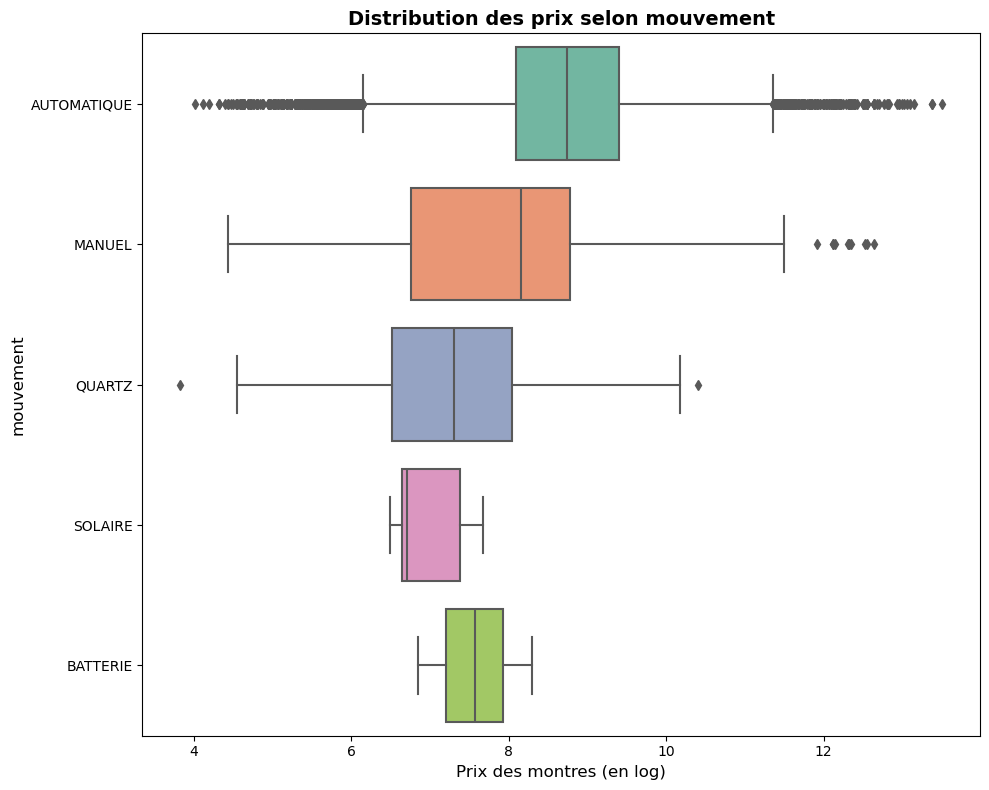

In [20]:
rep.boxplot('mouvement')

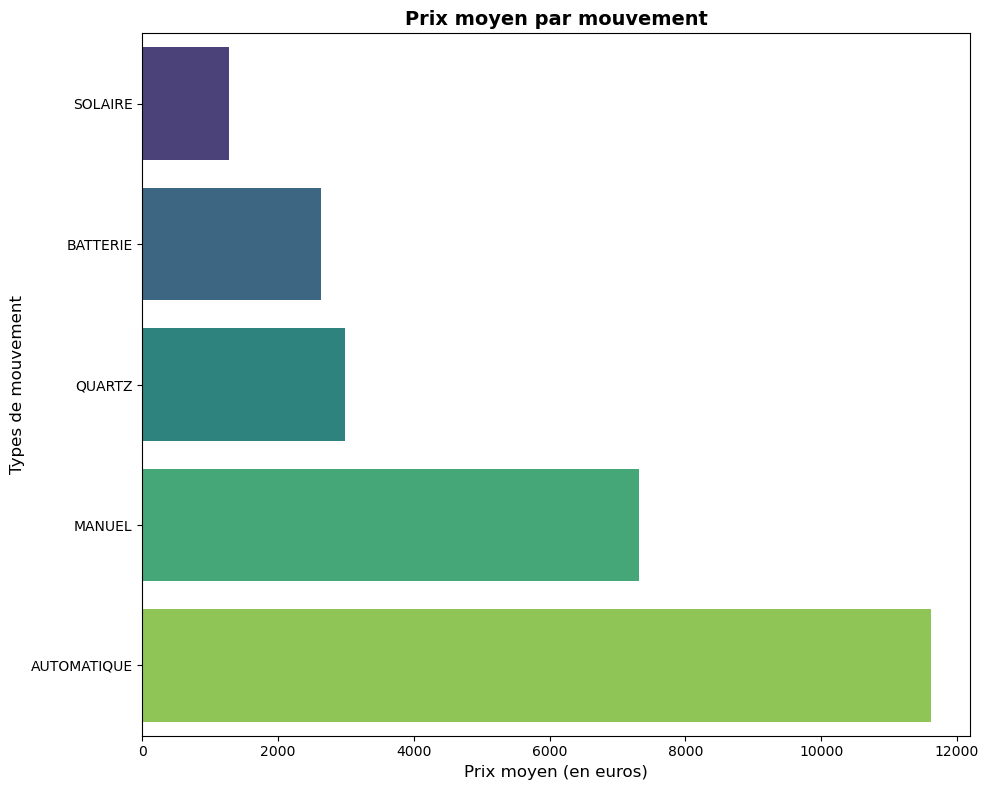

In [21]:
rep.barres('mouvement')

# Sexe 

In [22]:
rep.tableau('sexe')

           Statistiques par Sexe            
┏━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Sexe  ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ HOMME │   12027.96 │    49.00 │    49.00 │
│ FEMME │   10033.12 │    90.00 │    90.00 │
└───────┴────────────┴──────────┴──────────┘

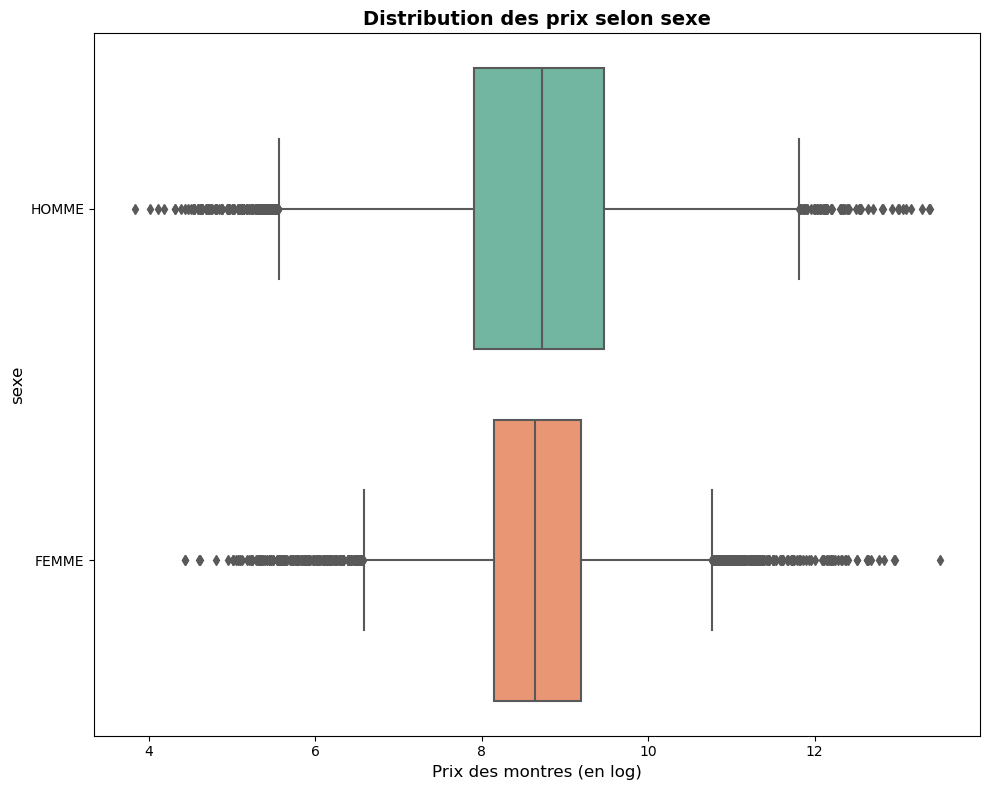

In [23]:
rep.boxplot('sexe')

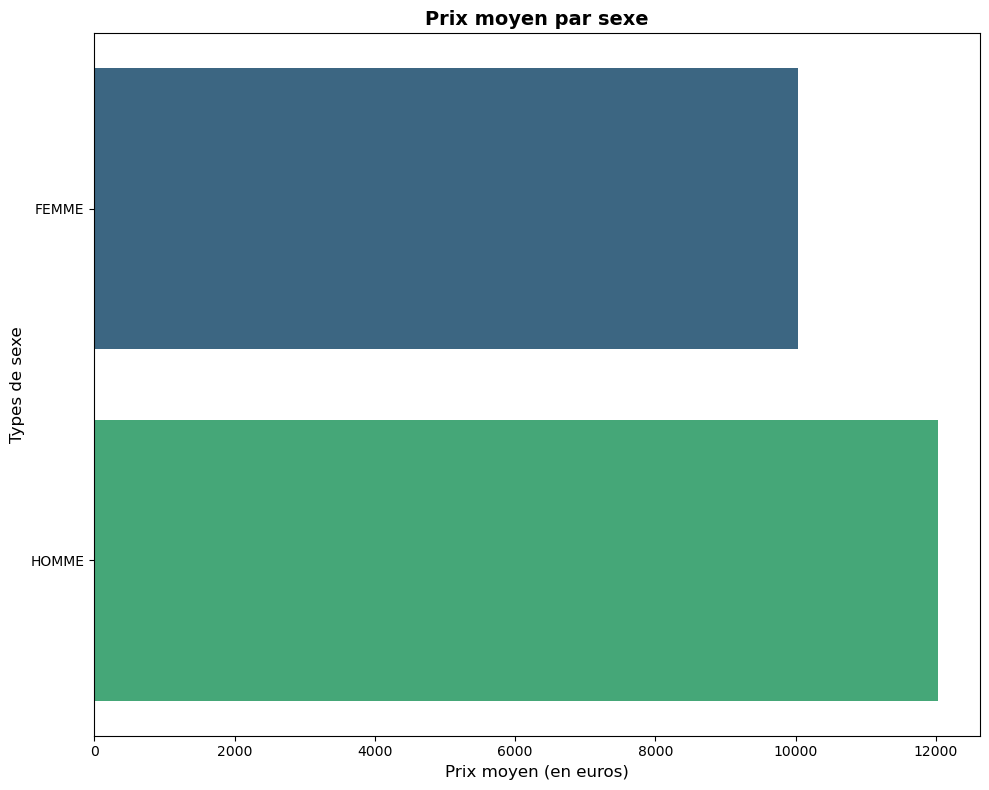

In [24]:
rep.barres('sexe')

# Marque 

In [25]:
rep.tableau('marque')

                  Statistiques par Marque                   
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃        Marque         ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│     RICHARD-MILLE     │  235473.26 │ 99900.00 │ 99900.00 │
│       FPJOURNE        │  133308.12 │ 51029.00 │ 51029.00 │
│      DE-BETHUNE       │   69900.00 │ 69900.00 │ 69900.00 │
│    PATEK-PHILIPPE     │   54761.17 │  2999.00 │  2999.00 │
│        URWERK         │   46072.00 │ 46072.00 │ 46072.00 │
│    AUDEMARS-PIGUET    │   45300.50 │  2000.00 │  2000.00 │
│    A-LANGE-&-SÖHNE    │   39630.93 │ 13300.00 │ 13300.00 │
│     HARRY-WINSTON     │   39272.50 │ 16946.00 │ 16946.00 │
│   MORITZ-GROSSMANN    │   29701.00 │ 29701.00 │ 29701.00 │
│         BOVET         │   26825.00 │ 25400.00 │ 25400.00 │
│  VAN-CLEEF-&-ARPELS   │   26360.00 │  7500.00 │  7500.00 │
│  VACHERON-CONSTANTIN  │   23380.38 │  2900.00 │  2900.00 │
│        BREGUET        │   21932.12 │  4250.00 │  4250.00 │
│     HMOSER-&-CIE      │   20142.55 │ 11489.00 │ 11489.00 │
│     ULYSSE-NARDIN     │   18180.34 │  3331.00 │  3331.00 │
│  PARMIGIANI-FLEURIER  │   18088.63 │  5696.00 │  5696.00 │
│     ROGER-DUBUIS      │   17034.73 │  5918.00 │  5918.00 │
│      JAQUET-DROZ      │   14496.92 │  4145.00 │  4145.00 │
│         ROLEX         │   13003.06 │   250.00 │   250.00 │
│        HUBLOT         │   12659.87 │  1400.00 │  1400.00 │
│        PIAGET         │   12238.82 │  1500.00 │  1500.00 │
│     FRANCK-MULLER     │   11929.42 │  1527.00 │  1527.00 │
│       BLANCPAIN       │   11291.92 │  1450.00 │  1450.00 │
│   GIRARD-PERREGAUX    │   11169.22 │  1100.00 │  1100.00 │
│        CHOPARD        │   11064.03 │   349.00 │   349.00 │
│     DE-GRISOGONO      │   10199.17 │  6500.00 │  6500.00 │
│         CORUM         │   10159.11 │  1370.00 │  1370.00 │
│     LOUIS-MOINET      │   10000.00 │ 10000.00 │ 10000.00 │
│        BULGARI        │    8307.49 │   809.00 │   809.00 │
│      JACOB-&-CO       │    8155.60 │  3990.00 │  3990.00 │
│         DIOR          │    7867.94 │  1200.00 │  1200.00 │
│   JAEGER-LECOULTRE    │    7817.53 │   550.00 │   550.00 │
│  GLASHÜTTE-ORIGINAL   │    7735.22 │  2600.00 │  2600.00 │
│        CARTIER        │    7461.18 │   495.00 │   495.00 │
│     GÉRALD-GENTA      │    7220.00 │  6900.00 │  6900.00 │
│          IWC          │    6702.23 │   700.00 │   700.00 │
│        PANERAI        │    6571.60 │  3446.00 │  3446.00 │
│       PEQUIGNET       │    6415.83 │   700.00 │   700.00 │
│        CHANEL         │    6385.14 │  1907.00 │  1907.00 │
│      GRAND-SEIKO      │    6317.49 │  1308.00 │  1308.00 │
│       BOUCHERON       │    6190.00 │  1990.00 │  1990.00 │
│      JORG-HYSEK       │    5697.25 │  2098.00 │  2098.00 │
│        ZENITH         │    5565.37 │    90.00 │    90.00 │
│        TIFFANY        │    5448.00 │  5448.00 │  5448.00 │
│        CHAUMET        │    5203.89 │   895.00 │   895.00 │
│   UNIVERSAL-GENÈVE    │    5054.21 │  1200.00 │  1200.00 │
│        GRAHAM         │    4991.00 │  2599.00 │  2599.00 │
│         OMEGA         │    4972.70 │    90.00 │    90.00 │
│      BEDAT-&-CO       │    4780.00 │  3567.00 │  3567.00 │
│       PERRELET        │    4423.00 │  1800.00 │  1800.00 │
│    CARL-F-BUCHERER    │    4382.18 │  1200.00 │  1200.00 │
│       BREITLING       │    4381.99 │   400.00 │   400.00 │
│          BRM          │    4099.67 │  3200.00 │  3200.00 │
│         TUDOR         │    3710.24 │   450.00 │   450.00 │
│        VULCAIN        │    3309.95 │  1290.00 │  1290.00 │
│      BELL-&-ROSS      │    3259.14 │  1250.00 │  1250.00 │
│       TAG-HEUER       │    3119.17 │   170.00 │   170.00 │
│    PORSCHE-DESIGN     │    3097.00 │  1250.00 │  1250.00 │
│         EBEL          │    2986.40 │   490.00 │   490.00 │
│     EBERHARD-&-CO     │    2733.11 │  1149.00 │  1149.00 │
│      JEANRICHARD      │    2666.00 │   900.00 │   900.00 │
│        HERMÈS         │    2600.8

### Matiere boitier 

In [26]:
rep.tableau('matiere_boitier')

           Statistiques par Matiere_boitier           
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Matiere_boitier ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│     PLATINE     │   76183.19 │  1516.00 │  1516.00 │
│     OR_ROSE     │   41411.76 │   290.00 │   290.00 │
│    OR_BLANC     │   28039.71 │   750.00 │   750.00 │
│     CARBONE     │   25312.20 │   250.00 │   250.00 │
│    OR_ROUGE     │   19095.45 │  3799.00 │  3799.00 │
│    OR_JAUNE     │   15813.35 │   160.00 │   160.00 │
│     TANTALE     │   14655.00 │  7000.00 │  7000.00 │
│    PALLADIUM    │   11900.00 │ 11900.00 │ 11900.00 │
│    OR_ACIER     │    9316.87 │    90.00 │    90.00 │
│     TITANE      │    9279.65 │   234.00 │   234.00 │
│      ACIER      │    8433.41 │    65.00 │    65.00 │
│    CÉRAMIQUE    │    7523.37 │   209.00 │   209.00 │
│     BRONZE      │    4278.77 │   700.00 │   700.00 │
│    ALUMINIUM    │    3318.33 │   290.00 │   290.00 │
│     ARGENT      │    2271.93 │   135.00 │   135.00 │
│   PLAQUÉE_OR    │    1618.98 │   350.00 │   350.00 │
│  VERRE_SAPHIR   │    1237.00 │  1237.00 │  1237.00 │
│    PLASTIQUE    │     807.16 │    80.00 │    80.00 │
└─────────────────┴────────────┴──────────┴──────────┘

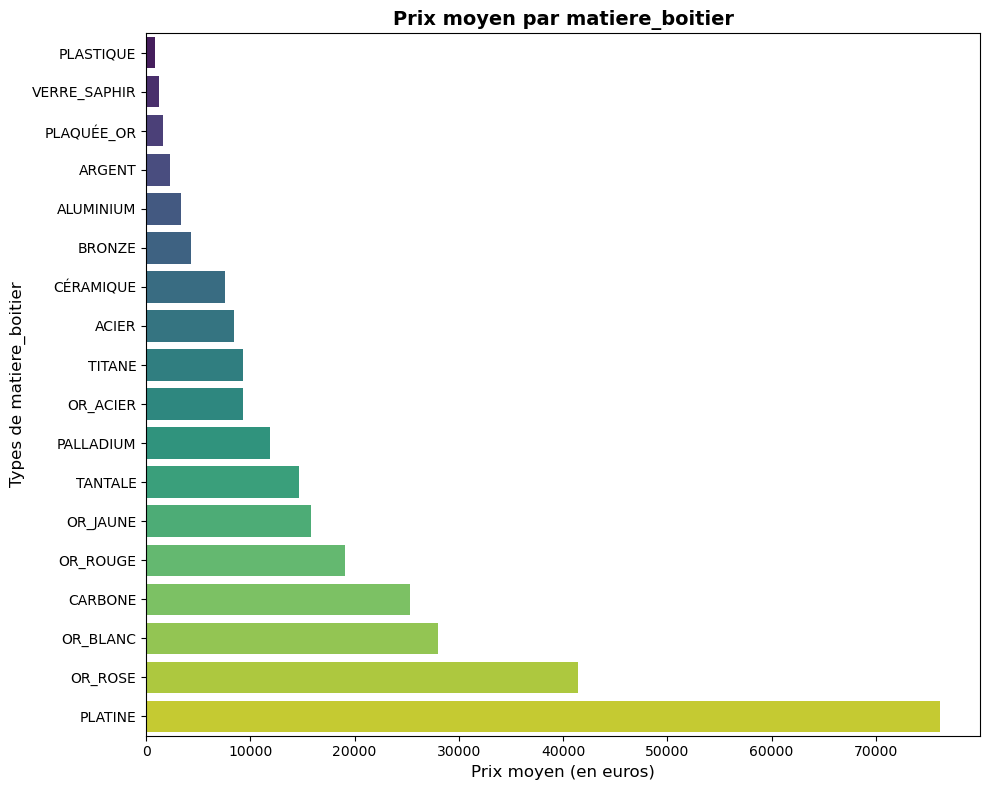

In [27]:
rep.barres('matiere_boitier')

### Matiere bracelet

In [28]:
rep.tableau('matiere_bracelet')

           Statistiques par Matiere_bracelet           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Matiere_bracelet ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│     PLATINE      │   82508.21 │  4080.00 │  4080.00 │
│     OR_ROSE      │   66541.32 │   630.00 │   630.00 │
│        OR        │   31325.94 │   350.00 │   350.00 │
│     OR_BLANC     │   20807.53 │   250.00 │   250.00 │
│      SATIN       │   20113.93 │   750.00 │   750.00 │
│    CAOUTCHOUC    │   19250.61 │    80.00 │    80.00 │
│     OR_JAUNE     │   16053.32 │  1195.00 │  1195.00 │
│      ACIER       │    9565.85 │    65.00 │    65.00 │
│     OR_ACIER     │    9556.35 │   169.00 │   169.00 │
│    CÉRAMIQUE     │    8513.96 │   490.00 │   490.00 │
│      TITANE      │    7516.48 │   234.00 │   234.00 │
│     OR_ROUGE     │    6966.00 │  4000.00 │  4000.00 │
│       CUIR       │    6696.09 │    90.00 │    90.00 │
│  CUIRE_DE_VACHE  │    5791.45 │   200.00 │   200.00 │
│    PLASTIQUE     │    5713.78 │   120.00 │   120.00 │
│      ARGENT      │    5266.61 │   240.00 │   240.00 │
│    ALUMINIUM     │    4950.00 │  4950.00 │  4950.00 │
│     TEXTILE      │    4265.76 │   118.00 │   118.00 │
│  CUIR_AUTRUCHE   │    4091.45 │   275.00 │   275.00 │
│     SILICONE     │    3360.60 │   250.00 │   250.00 │
│      BRONZE      │    1843.00 │  1300.00 │  1300.00 │
│      REQUIN      │     395.00 │   395.00 │   395.00 │
└──────────────────┴────────────┴──────────┴──────────┘

In [29]:
rep.tableau('matiere_bracelet')

           Statistiques par Matiere_bracelet           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Matiere_bracelet ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│     PLATINE      │   82508.21 │  4080.00 │  4080.00 │
│     OR_ROSE      │   66541.32 │   630.00 │   630.00 │
│        OR        │   31325.94 │   350.00 │   350.00 │
│     OR_BLANC     │   20807.53 │   250.00 │   250.00 │
│      SATIN       │   20113.93 │   750.00 │   750.00 │
│    CAOUTCHOUC    │   19250.61 │    80.00 │    80.00 │
│     OR_JAUNE     │   16053.32 │  1195.00 │  1195.00 │
│      ACIER       │    9565.85 │    65.00 │    65.00 │
│     OR_ACIER     │    9556.35 │   169.00 │   169.00 │
│    CÉRAMIQUE     │    8513.96 │   490.00 │   490.00 │
│      TITANE      │    7516.48 │   234.00 │   234.00 │
│     OR_ROUGE     │    6966.00 │  4000.00 │  4000.00 │
│       CUIR       │    6696.09 │    90.00 │    90.00 │
│  CUIRE_DE_VACHE  │    5791.45 │   200.00 │   200.00 │
│    PLASTIQUE     │    5713.78 │   120.00 │   120.00 │
│      ARGENT      │    5266.61 │   240.00 │   240.00 │
│    ALUMINIUM     │    4950.00 │  4950.00 │  4950.00 │
│     TEXTILE      │    4265.76 │   118.00 │   118.00 │
│  CUIR_AUTRUCHE   │    4091.45 │   275.00 │   275.00 │
│     SILICONE     │    3360.60 │   250.00 │   250.00 │
│      BRONZE      │    1843.00 │  1300.00 │  1300.00 │
│      REQUIN      │     395.00 │   395.00 │   395.00 │
└──────────────────┴────────────┴──────────┴──────────┘

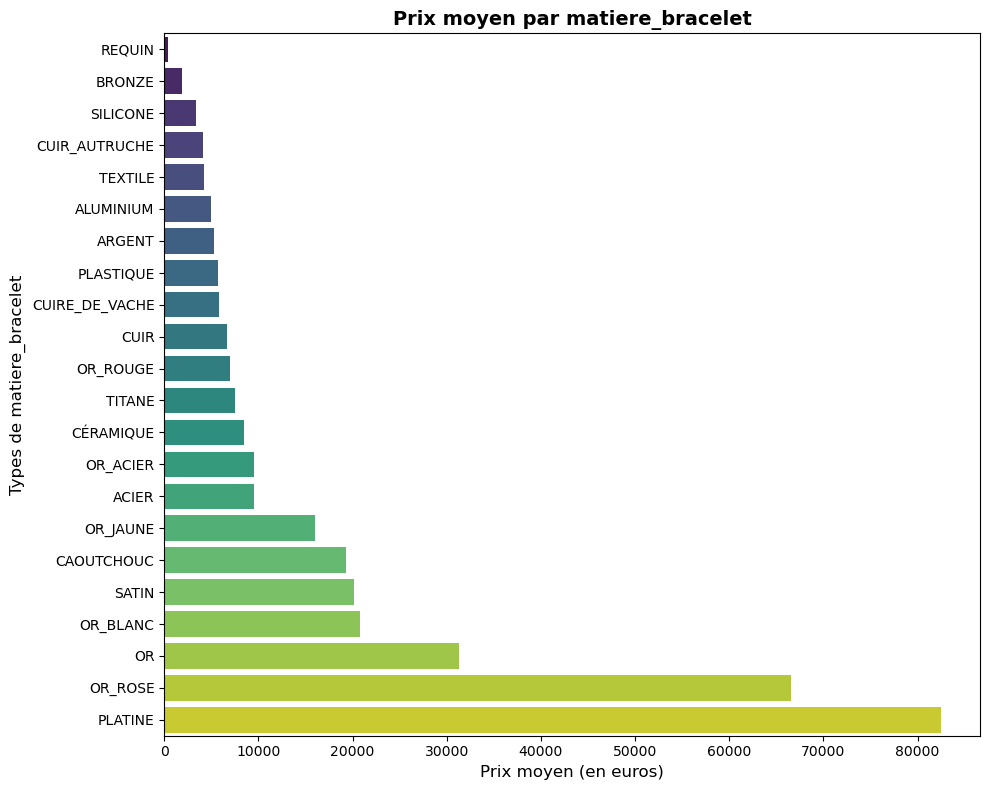

In [30]:
rep.barres('matiere_bracelet')

# Etat de la montre 

In [31]:
rep.tableau('etat')

                 Statistiques par Etat                  
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃       Etat        ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ État non spécifié │   14584.88 │   135.00 │   135.00 │
│       Neuf        │   13948.40 │    80.00 │    80.00 │
│        Bon        │   10185.28 │    49.00 │    49.00 │
│   Satisfaisant    │    5233.80 │    80.00 │    80.00 │
│    Défectueux     │    4430.79 │   100.00 │   100.00 │
└───────────────────┴────────────┴──────────┴──────────┘

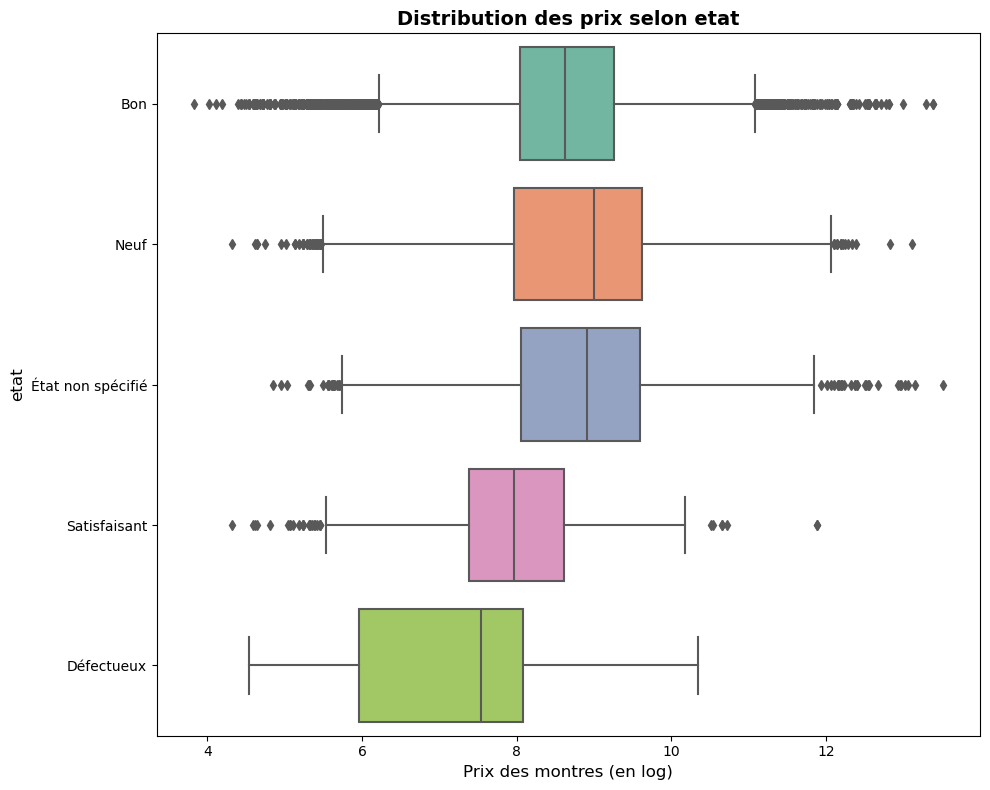

In [32]:
rep.boxplot('etat')

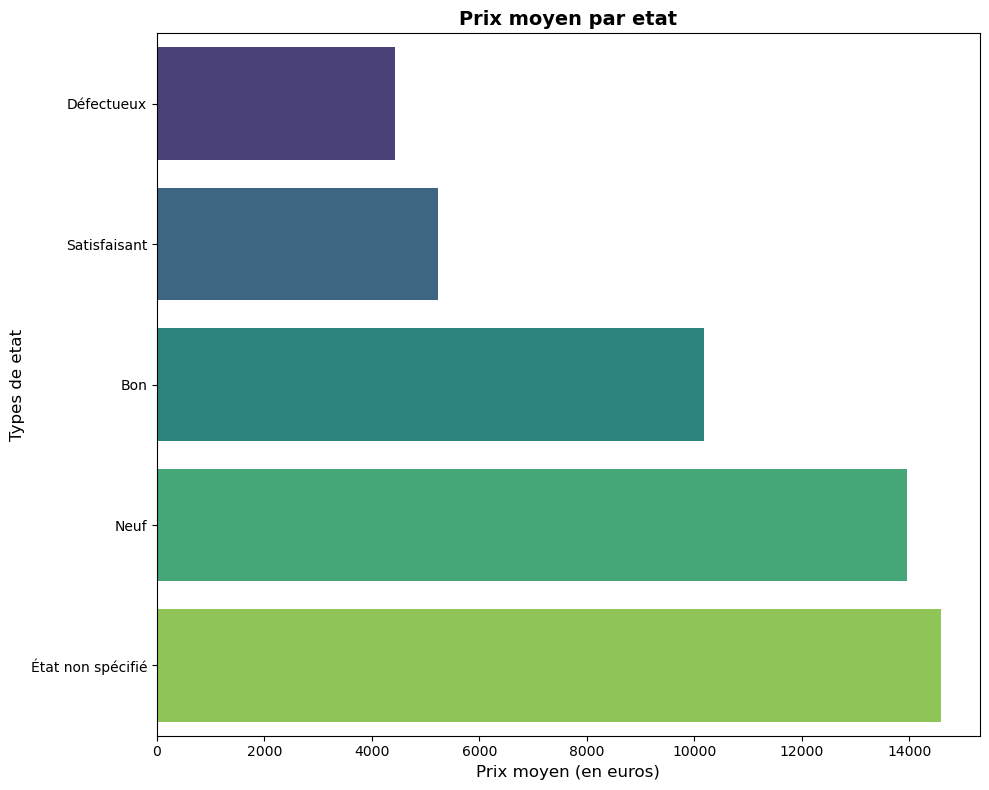

In [33]:
rep.barres('etat')

## matiere lunette : 

In [34]:
rep.tableau('matiere_lunette')

           Statistiques par Matiere_lunette           
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Matiere_lunette ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│     CARBONE     │   70952.56 │    90.00 │    90.00 │
│     OR_ROSE     │   27236.14 │   590.00 │   590.00 │
│     PLATINE     │   26019.10 │  1300.00 │  1300.00 │
│       OR        │   16418.70 │   160.00 │   160.00 │
│    CÉRAMIQUE    │   14404.36 │   209.00 │   209.00 │
│    OR_BLANC     │   12188.44 │   500.00 │   500.00 │
│     TITANE      │   10187.47 │   234.00 │   234.00 │
│      LISSE      │    8976.05 │  5499.00 │  5499.00 │
│    OR_JAUNE     │    8863.47 │   250.00 │   250.00 │
│      ACIER      │    8242.38 │    65.00 │    65.00 │
│    OR_ROUGE     │    6208.42 │  2750.00 │  2750.00 │
│    ALUMINIUM    │    4382.79 │   270.00 │   270.00 │
│     BRONZE      │    3512.50 │   800.00 │   800.00 │
│     ARGENT      │    3375.46 │   290.00 │   290.00 │
│    OR_ACIER     │    3347.33 │   169.00 │   169.00 │
│    PLASTIQUE    │    2355.88 │    80.00 │    80.00 │
│    TUNGSTÈNE    │    1635.57 │   370.00 │   370.00 │
│    PALLADIUM    │     550.00 │   550.00 │   550.00 │
└─────────────────┴────────────┴──────────┴──────────┘

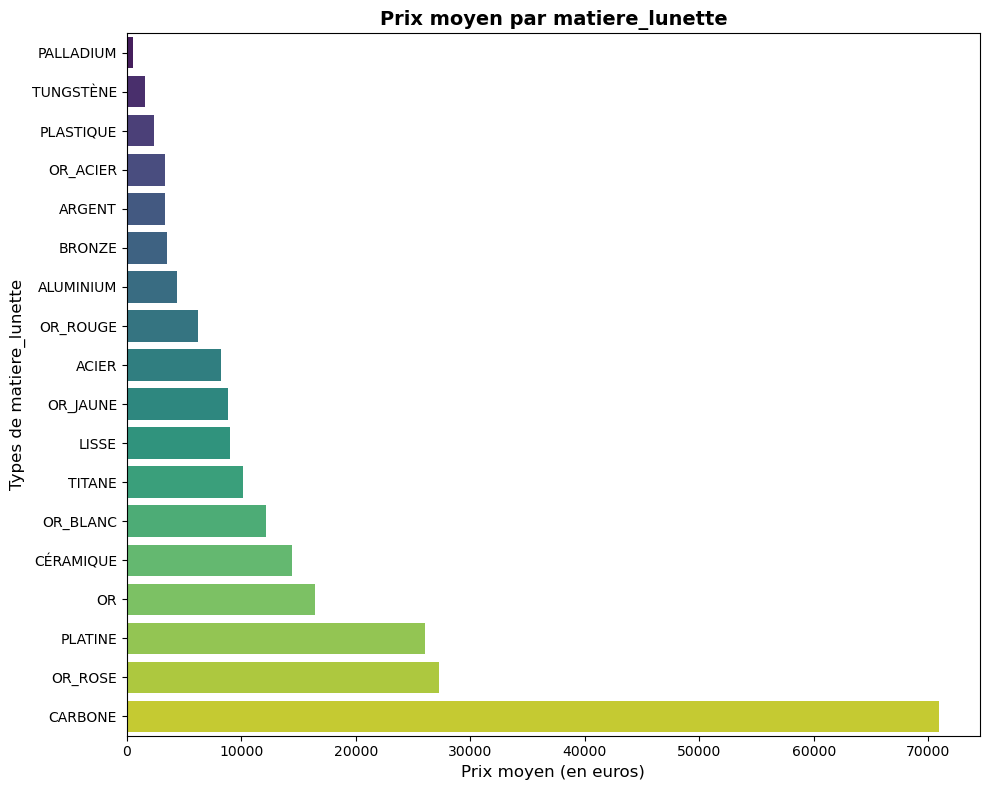

In [35]:
rep.barres('matiere_lunette')

### Matiere boucle

In [36]:
rep.tableau('matiere_boucle')

           Statistiques par Matiere_boucle           
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Matiere_boucle ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│    CARBONE     │   63280.11 │    90.00 │    90.00 │
│    PLATINE     │   27688.54 │  1516.00 │  1516.00 │
│       OR       │   14761.23 │   160.00 │   160.00 │
│   CÉRAMIQUE    │   14745.56 │   209.00 │   209.00 │
│     TITANE     │   10233.93 │   234.00 │   234.00 │
│     ACIER      │    7915.05 │    65.00 │    65.00 │
│    OR_ACIER    │    6612.05 │    90.00 │    90.00 │
│   ALUMINIUM    │    4708.69 │   270.00 │   270.00 │
│     BRONZE     │    3755.93 │  1190.00 │  1190.00 │
│     ARGENT     │    2352.34 │   106.00 │   106.00 │
│   PLASTIQUE    │    2282.54 │    80.00 │    80.00 │
│   TUNGSTÈNE    │    1299.75 │   370.00 │   370.00 │
│   PALLADIUM    │     550.00 │   550.00 │   550.00 │
└────────────────┴────────────┴──────────┴──────────┘

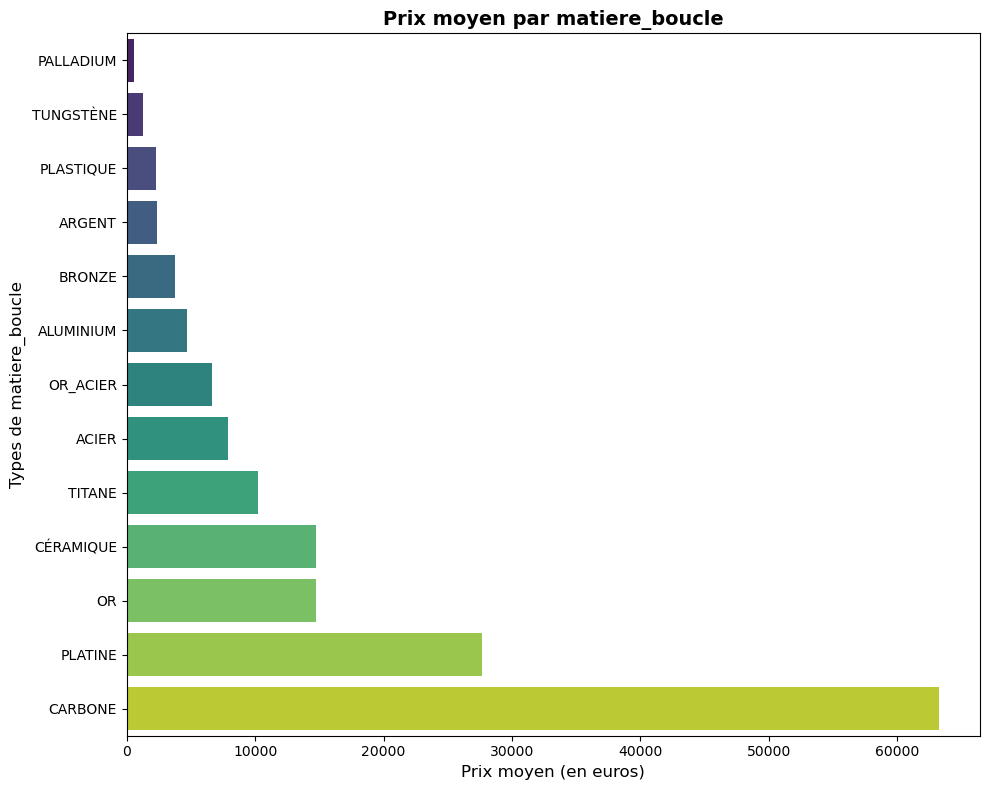

In [37]:
rep.barres('matiere_boucle')

### Boucle 

In [38]:
rep.tableau('boucle')

               Statistiques par Boucle                
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃     Boucle      ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│   DOUBLE_PLIS   │   14087.55 │    65.00 │    65.00 │
│      PLIS       │   11955.93 │    80.00 │    80.00 │
│ BOUCLE_ARDILLON │    7489.40 │    70.00 │    70.00 │
│ FERMOIR_BIJOUX  │    7423.26 │   240.00 │   240.00 │
│  PAS_DE_BOUCLE  │    4593.00 │   500.00 │   500.00 │
│ BOUCLE ARDILLON │    1407.00 │  1407.00 │  1407.00 │
└─────────────────┴────────────┴──────────┴──────────┘

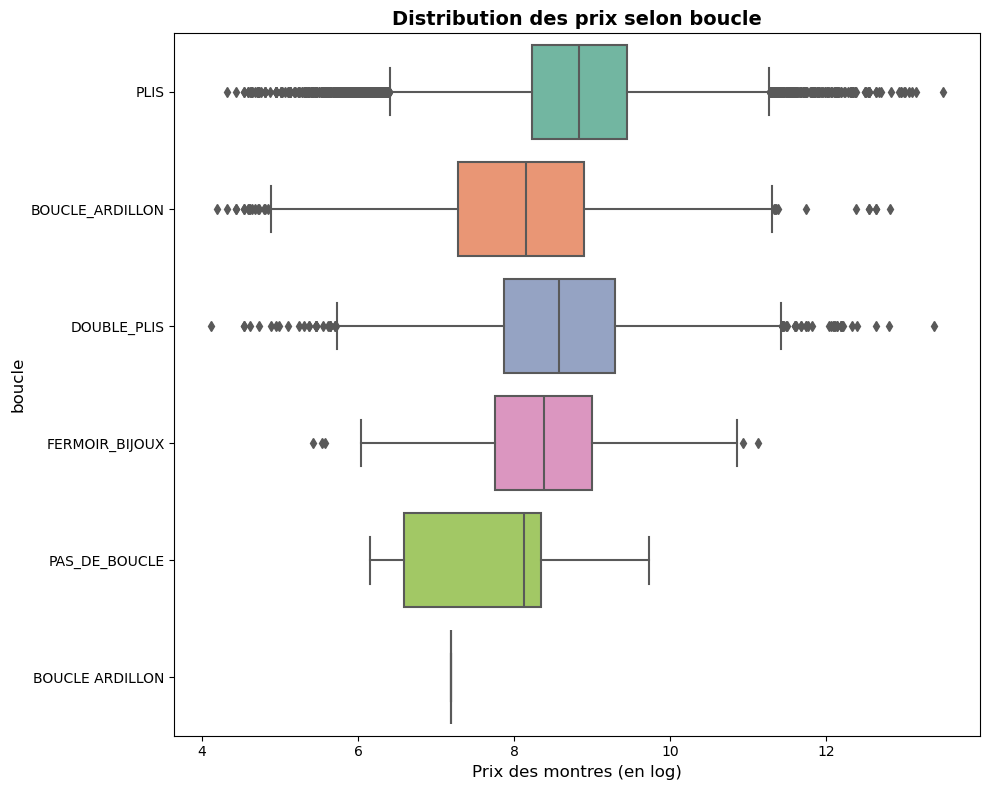

In [39]:
rep.boxplot('boucle')

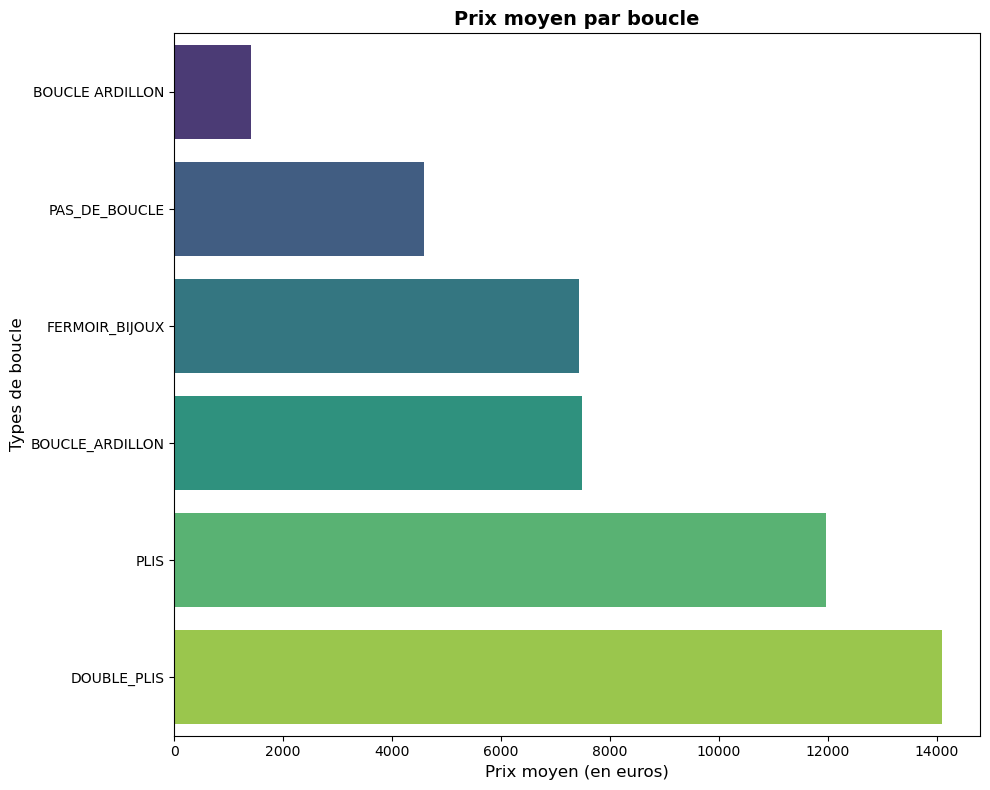

In [40]:
rep.barres('boucle')

# Nombre de complications 

In [41]:
rep.tableau('comptage_fonctions')

           Statistiques par Comptage_fonctions           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Comptage_fonctions ┃ Prix moyen ┃ Prix min ┃ Prix max ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│        6.0         │   25665.02 │   299.00 │   299.00 │
│        2.0         │   12303.73 │    80.00 │    80.00 │
│        4.0         │   12031.77 │   140.00 │   140.00 │
│        1.0         │   11586.17 │    70.00 │    70.00 │
│        5.0         │   11174.84 │   320.00 │   320.00 │
│        0.0         │   10203.92 │    49.00 │    49.00 │
│        3.0         │    9717.84 │    80.00 │    80.00 │
│        7.0         │    6564.76 │   250.00 │   250.00 │
│        8.0         │    3979.67 │   120.00 │   120.00 │
│        12.0        │    1950.00 │  1950.00 │  1950.00 │
│        9.0         │    1750.00 │  1750.00 │  1750.00 │
│        19.0        │    1468.00 │  1468.00 │  1468.00 │
│        10.0        │    1190.00 │  1100.00 │  1100.00 │
└────────────────────┴────────────┴──────────┴──────────┘

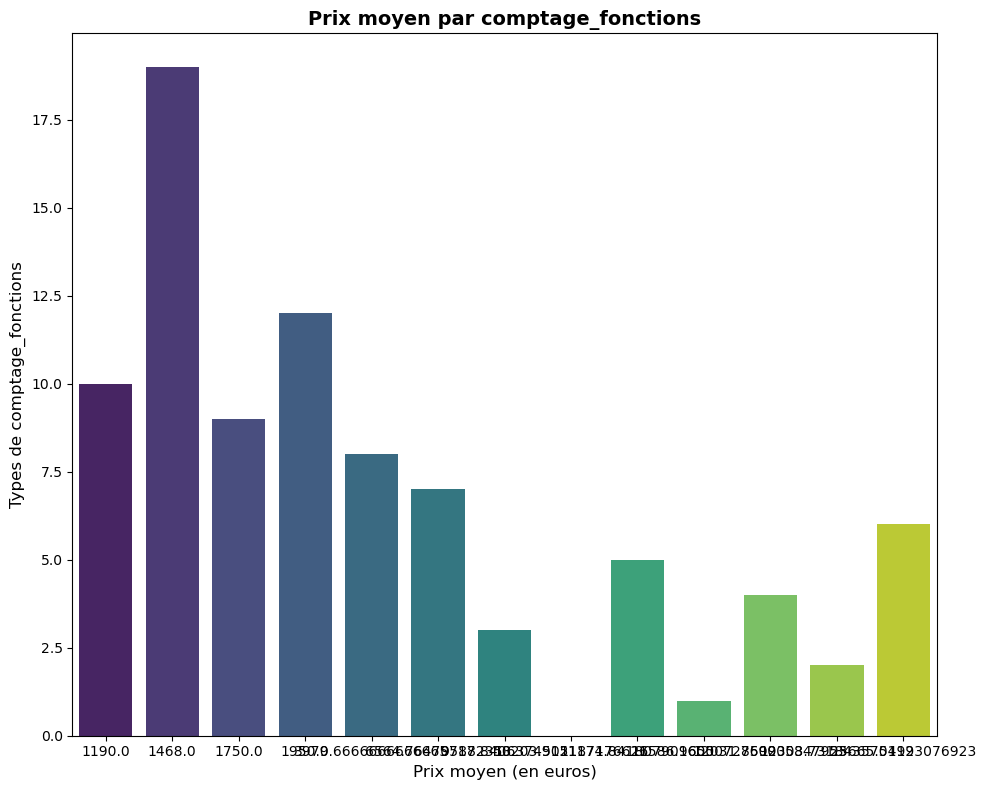

In [42]:
rep.barres('comptage_fonctions')

# Diamètre

<Axes: xlabel='diametre', ylabel='prix'>

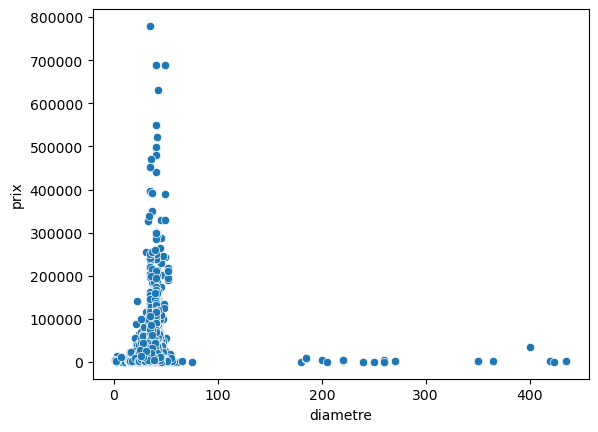

In [43]:
sns.scatterplot(x=df.diametre, y=df.prix)

# Etencheite

<Axes: xlabel='etencheite', ylabel='prix'>

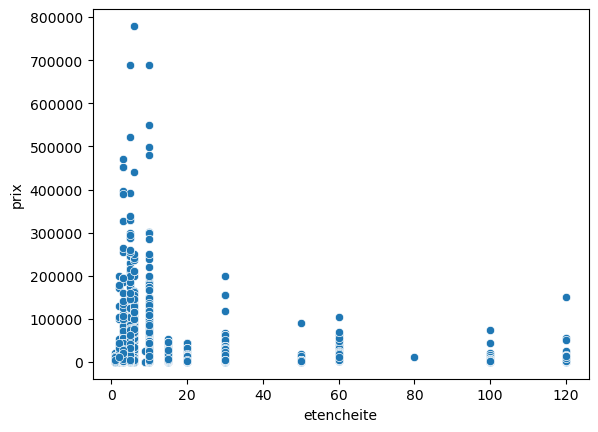

In [44]:
sns.scatterplot(x=df.etencheite, y=df.prix)

# Réserve de marche

<Axes: xlabel='reserve_de_marche', ylabel='prix'>

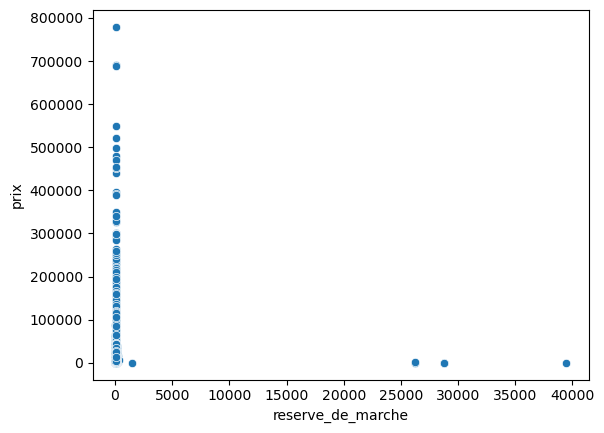

In [45]:
sns.scatterplot(x=df.reserve_de_marche, y=df.prix)

In [46]:
#Prétraitement : gérer les valeurs manquantes et conversion si nécessaire
df['prix'] = pd.to_numeric(df['prix'], errors='coerce').fillna(0)


# Application de IsolationForest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomalie'] = iso_forest.fit_predict(df[['prix']])

# Interprétation des résultats
df['anomalie'] = df['anomalie'].apply(lambda x: 'aberrant' if x == -1 else 'normal')
df = df[df['anomalie'] == 'normal']
df = df.drop(columns = ['anomalie'], axis = 1)

In [47]:
(df.isna().sum()/df.shape[0]*100).sort_values()

marque                 0.000000
modele                 0.000000
pays                   0.000000
etat                   0.000000
prix                   0.000000
comptage_fonctions     0.000000
mouvement              0.162806
sexe                   1.088763
matiere_boitier        1.258352
diametre               1.319404
matiere_boucle         3.232371
boucle                 3.680087
prix_log               4.317742
prix_sc                4.317742
matiere_verre          4.877387
matiere_lunette        5.104637
matiere_bracelet       8.211512
reserve_de_marche     12.088322
etencheite            12.383407
dtype: float64

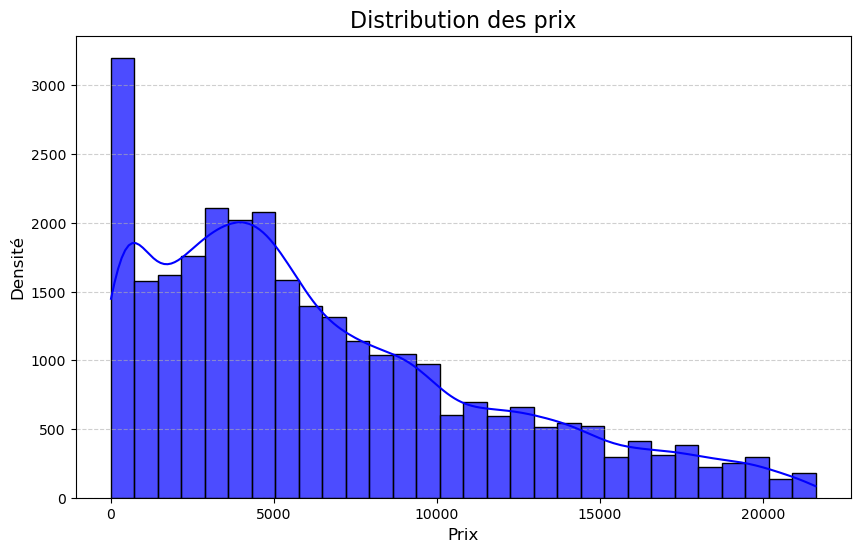

In [48]:
# Représentation de la distribution des prix
plt.figure(figsize=(10, 6))
sns.histplot(
    df['prix'], 
    bins=30, # Ajustez le nombre de bins selon la précision souhaitée
    kde=True, # Ajout d'une courbe de densité
    color="blue",
    alpha=0.7
)
plt.title("Distribution des prix", fontsize=16)
plt.xlabel("Prix", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Machine Learning 

Les modèles utilisés pour réaliser les estimations sont les suivants :
- Régression linéaire
- Lasso 
- Ridge 
- ElasticNet
- Estimateur de Theil Sen
- KNeighborsRegressor
- Forêt aléatoire
- SVM

In [49]:
X = df.drop(['prix_log', 'prix_sc', "prix"], axis=1)  # Remplacez 'target_column' par le nom de votre colonne cible
y = df['prix']  # Votre colonne cible

# Découpage en données d'apprentissage (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
print(f"{X_train.shape[0]:,} exemples d'entrainement pour {X_train.shape[1]} features.")
print(f"{X_test.shape[0]:,} exemples test.")

23,586 exemples d'entrainement pour 16 features.
5,897 exemples test.


In [51]:
quanti = [var for var in df.columns if fonc.is_numeric(df[var])]
quali = [var for var in df.columns if var not in quanti] 

print(f"Variables numériques: {len(quanti)}")
print(f"Variables dummies: {len(quali)}")

Variables numériques: 1
Variables dummies: 18


In [52]:
quanti = ['diametre',
          'reserve_de_marche',
          'etencheite', 
          'comptage_fonctions']
quali = ['marque', 
         'modele', 
         'mouvement',
         'matiere_boitier', 
         'matiere_bracelet',
         'etat', 
         'sexe',
         'matiere_lunette', 
         'matiere_verre', 
         'boucle', 
         'matiere_boucle',  
         'pays']

In [53]:
preprocessor=pred.preprocess(quanti, quali)

In [57]:
fit,resultat = pred.pipeline(preprocessor, X_train, y_train)

In [58]:
for k, v in sorted(resultat.items(), key=lambda x: x[1], reverse=True):
    print("%s: %s" % (k, v))

Ridge(): [0.663, 0.015]
Lasso(): [0.649, 0.017]
ElasticNet(): [0.27, 0.014]
KNeighborsRegressor(): [nan, nan]
RandomForestRegressor(random_state=10): [0.767, 0.013]
SVR(): [-0.064, 0.01]
LinearRegression(): [-2335015435331974.5, 3673347102507365.5]


# Optimisation des hyperparamètres :

## Moindres Carrées Ordinaires

In [59]:
pred.mco(fit[0], X_train, y_train)

,mean_train_score,std_train_score,mean_test_score,std_test_score,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer,param_preprocessor__num__scaler
5,0.699168,0.001536,-9.011107e+14,1.601061e+15,most_frequent,KNNImputer(),RobustScaler()
1,0.699202,0.001557,-1.798106e+15,2.555981e+15,most_frequent,SimpleImputer(strategy='median'),RobustScaler()
11,0.699784,0.001476,-2.335015e+15,3.673347e+15,constant,KNNImputer(),RobustScaler()
7,0.699569,0.001878,-5.258626e+16,1.518034e+17,constant,SimpleImputer(strategy='median'),RobustScaler()
9,0.699728,0.001515,-1.986496e+17,5.582862e+17,constant,SimpleImputer(),RobustScaler()


## Ridge 

In [60]:
pred.ridge(fit[1], X_train, y_train)

,param_regressor__alpha,mean_train_score,std_train_score,mean_test_score,std_test_score,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer,param_preprocessor__num__scaler
6,0.024822,0.698920,0.001003,0.658102,0.020829,constant,KNNImputer(),MinMaxScaler()
4,0.024822,0.698920,0.001003,0.658102,0.020828,constant,KNNImputer(),RobustScaler()
5,0.024822,0.698938,0.001010,0.658087,0.020858,constant,SimpleImputer(),MinMaxScaler()
1,0.024822,0.698933,0.001009,0.658080,0.020847,constant,SimpleImputer(strategy='median'),MinMaxScaler()
2,0.024822,0.698933,0.001009,0.658080,0.020847,constant,SimpleImputer(strategy='median'),RobustScaler()


## Lasso

In [61]:

pred.lasso(fit[2], X_train, y_train)

,param_regressor__alpha,mean_train_score,std_train_score,mean_test_score,std_test_score,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer,param_preprocessor__num__scaler
6,0.152812,0.693710,0.000984,0.661952,0.020765,constant,KNNImputer(),MinMaxScaler()
4,0.152812,0.693710,0.000984,0.661932,0.020761,constant,KNNImputer(),RobustScaler()
5,0.152812,0.693733,0.000990,0.661932,0.020813,constant,SimpleImputer(),MinMaxScaler()
1,0.152812,0.693729,0.000989,0.661926,0.020796,constant,SimpleImputer(strategy='median'),MinMaxScaler()
2,0.152812,0.693729,0.000989,0.661905,0.020796,constant,SimpleImputer(strategy='median'),RobustScaler()


## ElasticNet

In [62]:
pred.elasticnet(fit[3], X_train, y_train)

,param_regressor__l1_ratio,param_regressor__alpha,mean_train_score,std_train_score,mean_test_score,std_test_score,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer,param_preprocessor__num__scaler
2,0.211307,0.159705,0.405723,0.001379,0.403267,0.022945,constant,SimpleImputer(strategy='median'),RobustScaler()
4,0.211307,0.159705,0.405692,0.001406,0.403179,0.022932,constant,KNNImputer(),RobustScaler()
6,0.211307,0.159705,0.403748,0.001403,0.401549,0.023354,constant,KNNImputer(),MinMaxScaler()
1,0.211307,0.159705,0.403716,0.001405,0.401521,0.023350,constant,SimpleImputer(strategy='median'),MinMaxScaler()
5,0.211307,0.159705,0.403715,0.001405,0.401520,0.023351,constant,SimpleImputer(),MinMaxScaler()


## KNN

In [63]:
pred.knn(fit[4], X_train, y_train)

,param_regressor__n_neighbors,mean_train_score,std_train_score,mean_test_score,std_test_score,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer,param_preprocessor__num__scaler
0,6,NaN,NaN,NaN,NaN,constant,SimpleImputer(),MinMaxScaler()
1,3,NaN,NaN,NaN,NaN,most_frequent,KNNImputer(),RobustScaler()
2,14,NaN,NaN,NaN,NaN,constant,SimpleImputer(),RobustScaler()
3,10,NaN,NaN,NaN,NaN,constant,SimpleImputer(),MinMaxScaler()
4,14,NaN,NaN,NaN,NaN,constant,SimpleImputer(strategy='median'),MinMaxScaler()


## Forêt aléatoire

In [64]:
pred.foret(fit[5], X_train, y_train)

(  param_regressor__n_estimators param_regressor__max_depth  \
 9                           100                          6   
 5                           200                          5   
 8                           300                          2   
 4                           200                          7   
 0                           200                          3   
 
   param_regressor__criterion param_regressor__max_features  mean_train_score  \
 9                    poisson                          auto          0.577547   
 5              squared_error                          auto          0.560855   
 8              squared_error                          auto          0.381660   
 4                    poisson                          sqrt          0.333742   
 0              squared_error                          sqrt          0.170513   
 
    std_train_score  mean_test_score  std_test_score  \
 9         0.001615         0.567265        0.028305   
 5         0.001406 

## SVR

In [ ]:
pred.svr(fit[6], X_train,y_train)